In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import label_binarize

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay


In [2]:
# Define file names and column names
pred_csv = "predicted_af_fdset_30Mar.csv"
pred_id_col = "exam_ids"
pred_class_col = "predicted_class"
pred_prob = "prob_class"

true_csv = "traces100pc_exams_info.csv"
true_id_col = "id_exam"
true_class_col = "exam_class"

### Models are trained without weights

In [3]:
# Read predicted csv file
pred_df = pd.read_csv(pred_csv, index_col= pred_id_col)
#pred_ids = pred_df[pred_id_col]
pred_index = pred_df.index
pred_df.head(10)

,exam_ids.1,predicted_class,prob_class1,prob_class2,prob_class3,prob_class1_norm,prob_class3_norm
exam_ids,,,,,,,
21284,21284,1.0,0.998970,0.000035,0.000994,0.999006,0.000994
924386,924386,1.0,0.995386,0.000073,0.004541,0.995459,0.004541
2939231,2939231,1.0,0.990075,0.001023,0.008902,0.991089,0.008911
761745,761745,1.0,0.999566,0.000023,0.000411,0.999589,0.000411
713438,713438,1.0,0.999525,0.000031,0.000444,0.999556,0.000444
3181141,3181141,1.0,0.974425,0.010703,0.014872,0.984967,0.015033
2735976,2735976,1.0,0.996727,0.000202,0.003070,0.996929,0.003071
2975924,2975924,2.0,0.050890,0.906287,0.042822,0.543045,0.456955
298440,298440,1.0,0.999336,0.000084,0.000580,0.999420,0.000580


In [4]:
pred_index.values[:10]

array([  21284,  924386, 2939231,  761745,  713438, 3181141, 2735976,
       2975924,  298440,  910859], dtype=int64)

In [5]:
# Read exams info file
exams_df = pd.read_csv(true_csv, index_col = true_id_col)
exams_df.head(10)

,Unnamed: 0,id_patient,age,sex,AF,exam_class,split
id_exam,,,,,,,
29855,9,1303179,63,F,0,1,train
21284,10,149539,68,F,0,1,test
749729,16,445398,42,M,0,1,train
371322,17,68340,59,M,0,1,train
1384433,18,10854,48,F,0,1,valid
3200399,19,110344,38,F,0,1,train
603726,26,1464955,60,M,0,1,train
3187610,28,1024979,30,F,0,1,train
805692,32,56645,33,M,0,1,train


In [6]:
# predicted file stats
pred_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
exam_ids.1,198409.0,1.406998e+06,1.195965e+06,6.000000e+00,450257.000000,999152.000000,2.654971e+06,4.416611e+06
predicted_class,198409.0,1.018396e+00,1.343801e-01,1.000000e+00,1.000000,1.000000,1.000000e+00,2.000000e+00
prob_class1,198409.0,9.694213e-01,1.308192e-01,4.271106e-05,0.992350,0.997813,9.991153e-01,9.999998e-01
prob_class2,198409.0,2.067929e-02,1.241036e-01,2.889134e-11,0.000041,0.000105,5.068138e-04,9.993211e-01
prob_class3,198409.0,9.899429e-03,2.399948e-02,2.538773e-07,0.000808,0.001969,6.419622e-03,2.958830e-01
prob_class1_norm,198409.0,9.798277e-01,8.488599e-02,3.487835e-02,0.993396,0.998029,9.991923e-01,9.999997e-01
prob_class3_norm,198409.0,2.017229e-02,8.488599e-02,2.538773e-07,0.000808,0.001971,6.603865e-03,9.651216e-01


In [7]:
# true exams file stats
exams_df = exams_df.reindex(pred_index, fill_value=False, copy=True) # Keep ids that are in pred_csv file
print(exams_df.isnull().sum() ==0) # It should print True, all ids in pred_csv should be in true_csv
exams_df.describe().transpose()

Unnamed: 0    True
id_patient    True
age           True
sex           True
AF            True
exam_class    True
split         True
dtype: bool


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,198409.0,1.160147e+06,669621.491877,10.0,581455.0,1160688.0,1738580.0,2322505.0
id_patient,198409.0,5.751819e+05,567783.639443,7.0,97477.0,286182.0,1045433.0,1773677.0
age,198409.0,5.662240e+01,15.984995,17.0,46.0,58.0,68.0,104.0
AF,198409.0,1.538741e-02,0.123088,0.0,0.0,0.0,0.0,1.0
exam_class,198409.0,1.052593e+00,0.295015,1.0,1.0,1.0,1.0,3.0


In [8]:
# Number of patients in the test set and per class
n_test_c3 = exams_df[(exams_df['split']=='test') & (exams_df[true_class_col]==3)]['id_patient'].unique().shape[0]
n_test_c1 = exams_df[(exams_df['split']=='test') & (exams_df[true_class_col]==1)]['id_patient'].unique().shape[0]
n_test_c2 = exams_df[(exams_df['split']=='test') & (exams_df[true_class_col]==2)]['id_patient'].unique().shape[0]
print("The number of patients in the test set belonging to class 3 is: ", n_test_c3)
print("The number of patients in the test set belonging to class 1 is: ", n_test_c1)
print("The number of patients in the test set belonging to class 2 is: ", n_test_c2)

The number of patients in the test set belonging to class 3 is:  2016
The number of patients in the test set belonging to class 1 is:  116255
The number of patients in the test set belonging to class 2 is:  2016


In [9]:
exams_df[true_class_col].value_counts()

1    191665
3      3691
2      3053
Name: exam_class, dtype: int64

In [10]:
pred_df[pred_class_col].value_counts()

1.0    194759
2.0      3650
Name: predicted_class, dtype: int64

In [11]:
pred_values = np.array(pred_df[pred_class_col], dtype=np.int64)
true_values = np.array(exams_df[true_class_col])
prob_classes = np.array(pred_df[[pred_prob + str(1), pred_prob + str(2), pred_prob + str(3)]])
print(len(pred_values) == len(true_values))


True


In [12]:
def get_perform_metrics(true_val, pred_val):
    """ A method to check performance metrics: accuracy, precision, recall, F1-score and confusion matrix."""
    
    target_names = ['class 1', 'class 2', 'class 3']   # 3 classes 
    
    # Accuracy on test data
    print("\nAccuracy on test data.\n")
    accuracy = np.mean(pred_val == true_val)
    print ("Accuracy: ", accuracy)

    #Confusion matrix
    print ("\nConfusion matrix, DNN model\n")
    print(pd.crosstab(true_val, pred_val, rownames=['True_value'], colnames=['Predicted'], margins=True))
    
    #Classification report    
    print("\nTest report:")
    print(classification_report(true_val, pred_val, target_names=target_names, zero_division=0))
    
    # plots class distribution on test data, true and predicted values
    fig = plt.figure(figsize=(10, 14))
    df_y_test = pd.DataFrame(true_val)[0].value_counts()
    df_y_pred = pd.DataFrame(pred_val)[0].value_counts()
    ax1 = plt.subplot(2, 2, 1)
    df_y_test.plot(kind='bar')
    plt.title('True values distribution')
    plt.xlabel('AF class')
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    df_y_pred.plot(kind='bar')
    plt.title('Predicted values distribution')
    plt.xlabel('AF class')
    
    """Plot confusion matrice of the model"""
    
    #fig2 = plt.figure(figsize=(6, 6))
    ax3 = plt.subplot(2, 1, 2)
    ConfusionMatrixDisplay.from_predictions(true_val, pred_val, cmap = plt.cm.YlGnBu, ax=ax3)  

    ax3.set_title("Confusion Matrix: DNN model", fontsize = 16)
    ax3.set_xlabel('Predicted labels', fontsize = 15)
    ax3.set_ylabel('True labels', fontsize = 15)
    '''
    font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}
    plt.rc('font', **font) 
    '''
    plt.show()



def plot_confusion_matrices(y_true, y_pred):
    """Plot confusion matrices of differet models"""
    
    fig2 = plt.figure(figsize=(6, 4))
    ax = plt.subplot(1, 1, 1)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap = plt.cm.YlGnBu, ax=ax)  

    ax.set_title("Confusion Matrix: DNN model", fontsize = 16)
    ax.set_xlabel('Predicted labels', fontsize = 15)
    ax.set_ylabel('True labels', fontsize = 15)
    '''
    font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}
    plt.rc('font', **font) 
    '''
    plt.show()

plot_confusion_matrices(true_values, pred_values)



Accuracy on test data.

Accuracy:  0.9757269075495567

Confusion matrix, DNN model

Predicted        1     2     All
True_value                      
1           191065   600  191665
2              525  2528    3053
3             3169   522    3691
All         194759  3650  198409

Test report:
              precision    recall  f1-score   support

     class 1       0.98      1.00      0.99    191665
     class 2       0.69      0.83      0.75      3053
     class 3       0.00      0.00      0.00      3691

    accuracy                           0.98    198409
   macro avg       0.56      0.61      0.58    198409
weighted avg       0.96      0.98      0.97    198409



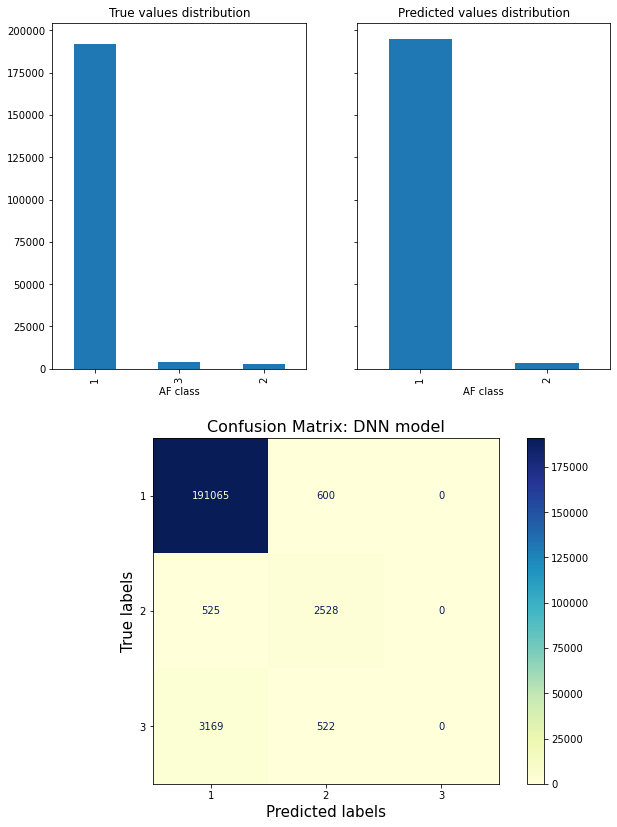

In [30]:
get_perform_metrics(true_values, pred_values)

### Plotting ROC Curve, get AUC Score

In [12]:

def plot_roc_curve(true_values, prob_classes):
    """Plot ROC curve for each class and get AUC scores"""

    fpr = {}
    tpr = {}
    thresh ={}

    n_classes = 3
    auc_scores = []

    random_probs = [0 for i in range(len(true_values))]
    rand_fpr, rand_tpr, _ = roc_curve(true_values, random_probs, pos_label=1)

    for i in range(n_classes):    
        fpr[i], tpr[i], thresh[i] = roc_curve(true_values, prob_classes[:,i], pos_label=i+1)
        auc_scores.append(auc(fpr[i], tpr[i]))
    
    # plotting
    fig = plt.figure(figsize=(8, 6))
    #plt.style.use('seaborn')
    plt.plot(fpr[0], tpr[0], label='Class 1 vs Rest, AUC = {:.3f}'.format(auc_scores[0]))
    plt.plot(fpr[1], tpr[1], label='Class 2 vs Rest, AUC = {:.3f}'.format(auc_scores[1]))
    plt.plot(fpr[2], tpr[2], label='Class 3 vs Rest, AUC = {:.3f}'.format(auc_scores[2]))
    plt.plot(rand_fpr, rand_tpr, linestyle='--', color='black')
    plt.title('Multiclass ROC curve', fontsize = 16)
    plt.xlabel('False Positive Rate', fontsize = 14)
    plt.ylabel('True Positive Rate', fontsize = 14)
    plt.legend(loc='best', fontsize = 12)
    #plt.savefig('Multiclass_ROC_curve.pdf',dpi=300); 
    plt.show()

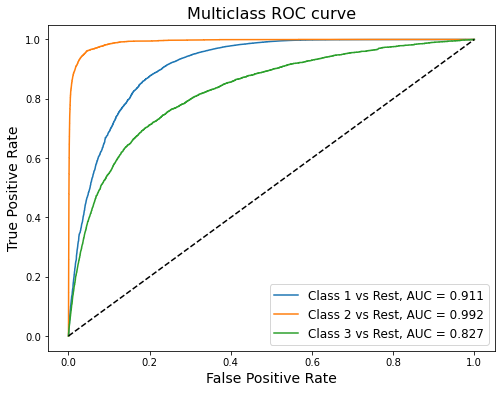

In [13]:
# roc curve for classes
plot_roc_curve(true_values, prob_classes)

In [14]:
overall_auc_score = roc_auc_score(true_values, prob_classes, multi_class='ovr', average="weighted") # weighted vs macro
overall_auc_score

0.910370592972769

In [15]:
auc_score_ovo = roc_auc_score(true_values, prob_classes, multi_class='ovo', average='weighted') # weighted vs macro
auc_score_ovo

0.9119231619993532

##### Compute Confidence Interval

In [16]:

def get_confidence_intervals(y_true, y_pred, function, score_name, average):
    """Compute bootstraped 95% Confidence Intervals for the scores"""
    bootstrap_iterations = 1000
    percentiles = [2.5, 97.5]
    scores_list = []

    # Get bootstraped samples
    np.random.seed(42)
    n = len(y_true)
    samples_index = np.random.randint(n, size = n * bootstrap_iterations)
    y_true_resampled = np.reshape(y_true[samples_index], (bootstrap_iterations, n))
    y_pred_resampled = np.reshape(y_pred[samples_index], (bootstrap_iterations, n))

    # Apply functions to get scores
    for i in range(bootstrap_iterations):
        metric = function(y_true_resampled[i,:], y_pred_resampled[i,:], average=average)
        scores_list.append(metric)

    scores_np = np.array(scores_list)
    scores_np.sort(axis=0)

    # Compute percentiles index and get percentiles
    p_index = [int(p / 100.0 * bootstrap_iterations) for p in percentiles]
    scores_percentiles = scores_np[p_index]
    # Convert percentiles to a dataframe
    scores_percentiles_df = pd.DataFrame(scores_percentiles, index=['lower', 'upper'], columns=[score_name])
    #display(scores_percentiles_df)

    # Compute distance from current metrics
    '''
    #current_metric = np.array(list(metrics_new.values()))
    print(current_metric)
    distance_from_metric = scores_percentiles - current_metric
    distance_from_metric_df = pd.DataFrame(distance_from_metric, index=['minus', 'plus'], columns=score_name)
    display(distance_from_metric_df)
    '''
    
    return scores_percentiles_df

In [17]:
encoder = OneHotEncoder()
Y_onehot = encoder.fit_transform(true_values[:, np.newaxis]).toarray()
class1_y_true = Y_onehot[:,0]
class2_y_true = Y_onehot[:,1]
class3_y_true = Y_onehot[:,2]

In [18]:
score_name = "AUC Score"
n_classes = 3
classes_auc_ci = {}
for i in range(n_classes):
    classes_auc_ci[i] = get_confidence_intervals( Y_onehot[:,i], prob_classes[:,i], roc_auc_score, score_name, None)
ovr_auc_cis =  pd.concat([x for y, x in classes_auc_ci.items()], keys=['class 1', 'class 2', 'class 3'], axis=0)
display(ovr_auc_cis)
#class1_auc_ci = get_confidence_intervals(class1_y_true, prob_classes[:,0], roc_auc_score, score_name, None)

AUC Score
class 1 lower   0.906619
        upper   0.915127
class 2 lower   0.990920
        upper   0.992940
class 3 lower   0.820479
        upper   0.834172

#### Get the AUC score of class 3 VS class 1

In [19]:

#pred_df[[pred_prob + str(1), pred_prob + str(2), pred_prob + str(3)]]

# Get normalised values of probabilities of classes 3 & 1 -> to sum to 1.0 
three_vs_one_df = pd.DataFrame()
three_vs_one_df["class3_norm"] = pred_df[pred_prob + str(3)] / (pred_df[pred_prob + str(3)] + pred_df[pred_prob + str(1)])
three_vs_one_df["class1_norm"] = pred_df[pred_prob + str(1)] / (pred_df[pred_prob + str(3)] + pred_df[pred_prob + str(1)])
three_vs_one_df["sum_to_one"] = three_vs_one_df["class1_norm"] + three_vs_one_df["class3_norm"]
three_vs_one_df.head(10)

,class3_norm,class1_norm,sum_to_one
exam_ids,,,
21284,0.000994,0.999006,1.0
924386,0.004541,0.995459,1.0
2939231,0.008911,0.991089,1.0
761745,0.000411,0.999589,1.0
713438,0.000444,0.999556,1.0
3181141,0.015033,0.984967,1.0
2735976,0.003071,0.996929,1.0
2975924,0.456955,0.543045,1.0
298440,0.000580,0.999420,1.0


In [20]:
encoder = OneHotEncoder()
Y_onehot = encoder.fit_transform(true_values[:, np.newaxis]).toarray()
true_class3 = Y_onehot[:,2]
true_class1 = Y_onehot[:,0]
prob_class3_norm = np.array(three_vs_one_df["class3_norm"])
prob_class1_norm = np.array(three_vs_one_df["class1_norm"])

# Remove rows with class = 2
three_one_mask = true_values != 2
true_class3 = true_class3[three_one_mask]
true_class1 = true_class1[three_one_mask]
prob_class3_norm = prob_class3_norm[three_one_mask]
prob_class1_norm = prob_class1_norm[three_one_mask]

In [21]:
# Get the AUC score of class 3 VS class 1
three_vs_one_auc_score = roc_auc_score(true_class3, prob_class3_norm, average=None)
three_vs_one_auc_score

0.8449154337409821

In [22]:
one_vs_three_auc_score = roc_auc_score(true_class1, prob_class1_norm, average=None)
one_vs_three_auc_score

0.844915433740982

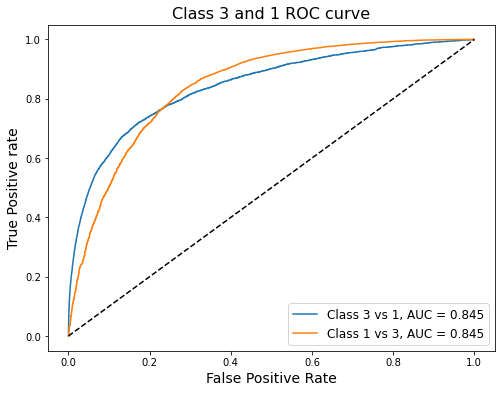

In [23]:
# Plot ROC Curve for Three vs One

random_probs = [0 for i in range(len(true_class3))]
rand_fpr, rand_tpr, _ = roc_curve(true_class3, random_probs, pos_label=1)
   
fpr_3, tpr_3, thresh_3 = roc_curve(true_class3, prob_class3_norm, pos_label=1)
fpr_1, tpr_1, thresh_1 = roc_curve(true_class1, prob_class1_norm, pos_label=1)
auc_scores_3 = auc(fpr_3, tpr_3)
auc_scores_1 = auc(fpr_1, tpr_1)
    
# plotting
fig = plt.figure(figsize=(8, 6))
#plt.style.use('seaborn')
plt.plot(fpr_3, tpr_3, label='Class 3 vs 1, AUC = {:.3f}'.format(auc_scores_3))
plt.plot(fpr_1, tpr_1, label='Class 1 vs 3, AUC = {:.3f}'.format(auc_scores_1))
plt.plot(rand_fpr, rand_tpr, linestyle='--', color='black')
plt.title('Class 3 and 1 ROC curve', fontsize = 16)
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive rate', fontsize = 14)
plt.legend(loc='best', fontsize = 12)
#plt.savefig('roc_curve_3vs1',dpi=300); 
plt.show()

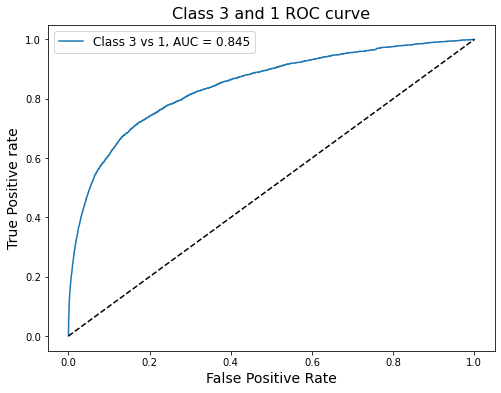

In [24]:
# plotting only one curve
fig = plt.figure(figsize=(8, 6))
#plt.style.use('seaborn')
plt.plot(fpr_3, tpr_3, label='Class 3 vs 1, AUC = {:.3f}'.format(auc_scores_3))
#plt.plot(fpr_1, tpr_1, label='Class 1 vs 3, AUC = {:.3f}'.format(auc_scores_1))
plt.plot(rand_fpr, rand_tpr, linestyle='--', color='black')
plt.title('Class 3 and 1 ROC curve', fontsize = 16)
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive rate', fontsize = 14)
plt.legend(loc='best', fontsize = 12)
#plt.savefig('roc_curve_3vs1.pdf',dpi=512); 
plt.show()

In [25]:
three_vs_one_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
class3_norm,198409.0,0.020172,8.488599e-02,2.538773e-07,0.000808,0.001971,0.006604,0.965122
class1_norm,198409.0,0.979828,8.488599e-02,3.487835e-02,0.993396,0.998029,0.999192,1.000000
sum_to_one,198409.0,1.000000,4.111902e-17,1.000000e+00,1.000000,1.000000,1.000000,1.000000


In [26]:
# One hot encoding
encoder = OneHotEncoder()
n_classes = 3


In [42]:

def overall_roc_curve(true_values, prob_classes):
    """plot the overall ROC curve for all classes"""
    
    Y_onehot = encoder.fit_transform(true_values[:, np.newaxis]).toarray()
    ov_fpr, ov_tpr, ov_threshold = roc_curve(Y_onehot.ravel(), prob_classes.ravel())

    plt.figure(figsize=(8, 8))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(ov_fpr, ov_tpr, label='AUC = {:.3f}'.format(auc(ov_fpr, ov_tpr)))
    plt.xlabel('False positive rate', fontsize = 13)
    plt.ylabel('True positive rate', fontsize = 13)
    plt.title('ROC curve', fontsize = 16)
    plt.legend(loc='best', fontsize = 13)
    plt.show()

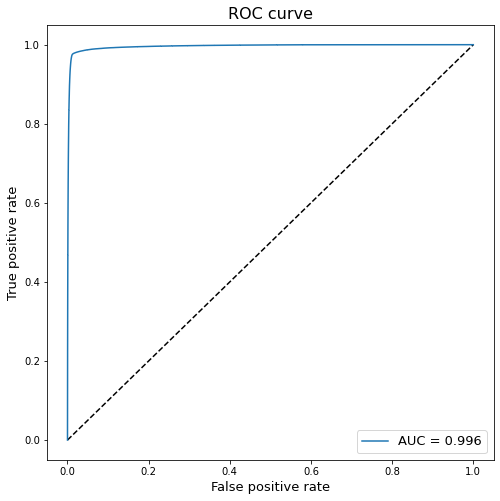

In [43]:
# Plotting the overall ROC curve
overall_roc_curve(true_values, prob_classes)

### Plotting the Precision-Recall curve

In [27]:
# Precision, Recall and Average Precision Score

def get_precision_recall_values(true_values, prob_classes):
    """Get values for precision, recall and average precision score"""
    
    # Use label_binarize to make multi-label like variable
    true_onehot = label_binarize(true_values, classes=[1, 2, 3])

    # For each class get performance data
    precision = dict()
    recall = dict()
    average_precision = dict()

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(true_onehot[:, i], prob_classes[:, i])
        average_precision[i] = average_precision_score(true_onehot[:, i], prob_classes[:, i], average='micro')

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], t_ = precision_recall_curve(true_onehot.ravel(), prob_classes.ravel())
    average_precision["micro"] = average_precision_score(true_onehot, prob_classes, average="micro")
    
    return precision, recall, average_precision


In [28]:
# Plot the micro-averaged Precision-Recall curve

def plot_micro_averaged_prcurve(precision, recall, average_precision):
    """Plot the micro-averaged Precision-Recall curve"""
    
    
    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    
    display.plot()
    _ = display.ax_.set_title("Precision-Recall, Micro-averaged over all classes", fontsize = 14)
    _ = display.ax_.set_xlabel("Recall", fontsize = 13)
    _ = display.ax_.set_ylabel("precision", fontsize = 13)

In [29]:
# Plot Precision-Recall curve for each class and iso-f1 curves
from itertools import cycle
def plot_precision_recall_curve(precision, recall, average_precision):
    """Plot Precision-Recall curve for each class and iso-f1 curves"""

    # setup plot details
    colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

    #plt.style.use('seaborn')
    plt.style.use('default')
    _, ax = plt.subplots(figsize=(7, 7))

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02), fontsize = 12)

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

    for i, color in zip(range(n_classes), colors):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {i+1}", color=color)

    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="best", fontsize = 12)
    ax.set_title("Precision-Recall curve for multi-class", fontsize = 14)
    plt.rc('font', size=12)
    #ax.xaxis.label.set_size(12)
    #ax.yaxis.label.set_size(12)
    #ax.tick_params(axis='both', labelsize=12)
    #plt.savefig('Precision_Recall_curve.pdf',dpi=300)
    
    plt.show()


In [30]:
precision, recall, average_precision = get_precision_recall_values(true_values, prob_classes)

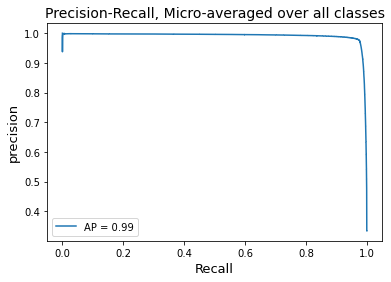

In [31]:
# Plot the micro-averaged Precision-Recall curve
plot_micro_averaged_prcurve(precision, recall, average_precision)

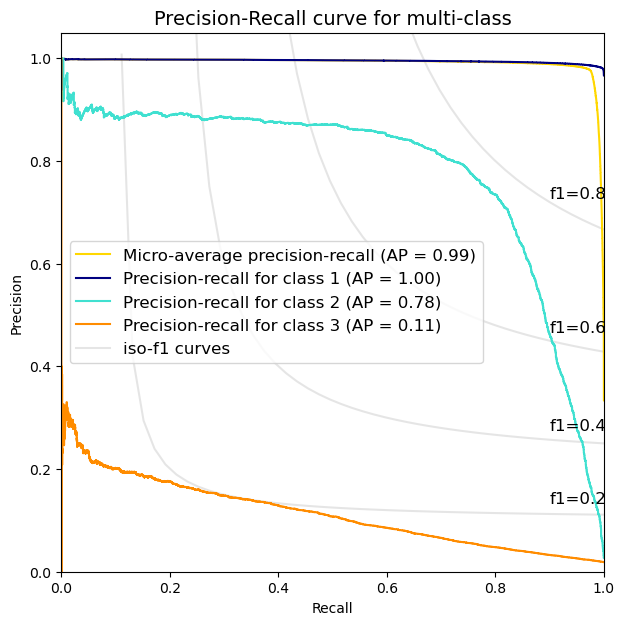

In [32]:
# Plot Precision-Recall curve for each class and iso-f1 curves
plot_precision_recall_curve(precision, recall, average_precision)

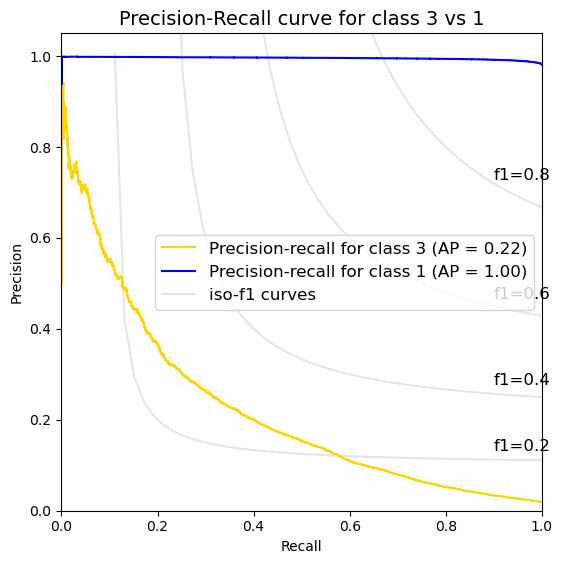

In [33]:
# Plotting precision recall curve for class 3 vs 1

precision_3, recall_3, _ = precision_recall_curve(true_class3, prob_class3_norm )
average_precision_3 = average_precision_score(true_class3, prob_class3_norm , average='micro')

precision_1, recall_1, _ = precision_recall_curve(true_class1, prob_class1_norm )
average_precision_1 = average_precision_score(true_class1, prob_class1_norm , average='micro')

#plt.style.use('seaborn')
plt.style.use('default')
_, ax = plt.subplots(figsize=(6.2, 6.2))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02), fontsize = 12)

display = PrecisionRecallDisplay(
    recall=recall_3,
    precision=precision_3,
    average_precision=average_precision_3,
    )
display.plot(ax=ax, name="Precision-recall for class 3", color="gold")

display = PrecisionRecallDisplay(
    recall=recall_1,
    precision=precision_1,
    average_precision=average_precision_1,
    )
display.plot(ax=ax, name=f"Precision-recall for class 1", color="blue")

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best", fontsize = 12)
ax.set_title("Precision-Recall curve for class 3 vs 1", fontsize = 14)
plt.rc('font', size=12)
#ax.xaxis.label.set_size(12)
#ax.yaxis.label.set_size(12)
#ax.tick_params(axis='both', labelsize=12)
#plt.savefig('Prec_Recall_curve_3vs1.pdf',dpi=300)

plt.show()


### Getting the threshold for class 1 vs class 3 (maximizing f1 score) and Producing the metrics: 
#### Precision, recall, f1 score, specificity:

In [51]:
def get_optimal_precision_recall(y_true, y_score):
    """Find precision and recall values that maximize f1 score."""
    """y_score is an array of prediction probabilities of class 3 (normalized)."""
    """y_true is an array of true values/labels for class 3 <- one-hot encoding."""

    # Get precision-recall curve
    precision, recall, threshold = precision_recall_curve(y_true, y_score)
    # Compute f1 score for each point (use nan_to_num to avoid nans messing up the results)
    f1_score = np.nan_to_num(2 * precision * recall / (precision + recall))
    # Select threshold that maximize f1 score
    index = np.argmax(f1_score)
    opt_precision = precision[index]
    opt_recall = recall[index]
    t = threshold[index-1] if index != 0 else threshold[0]-1e-10
    opt_threshold = t
    max_f1_score = f1_score[index]
 
    return opt_precision, opt_recall, opt_threshold, max_f1_score

In [52]:
# Get optimum precision, recall and threshold
opt_precision, opt_recall, opt_threshold, max_f1_score = get_optimal_precision_recall(true_class3, prob_class3_norm)
print(f"Optimum values are:\n\tPrecision: {opt_precision}\n\tRecall: {opt_recall}"\
        f"\n\tThreshold: {opt_threshold}\n\tMax F1 score: {max_f1_score}")

Optimum values are:
	Precision: 0.2657225156024964
	Recall: 0.29991872121376323
	Threshold: 0.11516120521390125
	Max F1 score: 0.28178694158075607


In [53]:
# Get deep neural network prediction
mask_pred = prob_class3_norm > opt_threshold   # prob_class3_norm (y_score) is the prediction probability of class 3 (normalized)

y_pred_class3 = np.zeros_like(prob_class3_norm)
y_pred_class3[mask_pred] = 1

# Confusion matrix
print ("\nConfusion matrix, DNN model\n")
print(pd.crosstab(true_class3, y_pred_class3, rownames=['True_value'], colnames=['Predicted'], margins=True))

# Classification report
target_names = ['class 1', 'class 3']     
print("\nPrediction report on test data:")
print(classification_report(true_class3, y_pred_class3, target_names=target_names, zero_division=0))


Confusion matrix, DNN model

Predicted      0.0   1.0     All
True_value                      
0.0         188606  3059  191665
1.0           2584  1107    3691
All         191190  4166  195356

Prediction report on test data:
              precision    recall  f1-score   support

     class 1       0.99      0.98      0.99    191665
     class 3       0.27      0.30      0.28      3691

    accuracy                           0.97    195356
   macro avg       0.63      0.64      0.63    195356
weighted avg       0.97      0.97      0.97    195356



In [54]:
# Another way of getting the metrics (for verification purposes)

from sklearn.metrics import (confusion_matrix, precision_score, recall_score, f1_score)

def get_scores(y_true, y_pred):
    scores = {}
    scores['Precision'] = precision_score(y_true, y_pred)
    scores['Recall'] = recall_score(y_true, y_pred)
    scores['F1 score'] = f1_score(y_true, y_pred)

    return scores


In [55]:
#  Get specificity metric

def specificity_score(y_true, y_pred):
    m = confusion_matrix(y_true, y_pred, labels=[0, 1])
    spc = m[0, 0] * 1.0 / (m[0, 0] + m[0, 1])
    return spc  


In [56]:
#Get metrics
metrics = get_scores(true_class3, y_pred_class3)
specificity = specificity_score(true_class3, y_pred_class3)

# Printing the metrics
metrics['Specificity'] = specificity

for item, value in metrics.items():
    print(item,": ", round(value,3))

Precision :  0.266
Recall :  0.3
F1 score :  0.282
Specificity :  0.984


#### Getting the threshold for class 1 vs class 3 using validation data, then produce metrics

In [57]:
# Define validation file names and column names
valid_csv = "predicted_af_valid_30Mar.csv"
valid_id_col = "exam_ids"
valid_class_col = "predicted_class"
valid_prob = "prob_class"


# Read validation csv file  (exam_ids, prob_class1, prob_class2, prob_class3, prob_class1_norm,	prob_class3_norm)
valid_df = pd.read_csv(valid_csv, index_col= valid_id_col)
valid_index = valid_df.index
valid_df.shape

(68854, 7)

In [58]:
# Read exams info file
exams_df2 = pd.read_csv(true_csv, index_col = true_id_col)
exams_df2 = exams_df2.reindex(valid_index, fill_value=False, copy=True) # Keep ids that are in valid_csv file
exams_df2[true_class_col].value_counts()

1    63433
2     4225
3     1196
Name: exam_class, dtype: int64

In [59]:
# Get predicted and true values
pred_v_values = np.array(valid_df[valid_class_col], dtype=np.int64)
true_v_values = np.array(exams_df2[true_class_col])
prob_v_classes = np.array(valid_df[[valid_prob + str(1), valid_prob + str(2), valid_prob + str(3)]])
print(len(pred_v_values) == len(true_v_values))

True


In [60]:
# Get probabilities and true values for class 3 vs 1
encoder = OneHotEncoder()
Y_onehot_v = encoder.fit_transform(true_v_values[:, np.newaxis]).toarray()
true_v_class3 = Y_onehot_v[:,2]
prob_v_class3_norm = np.array(valid_df[valid_prob + str(3)] / (valid_df[valid_prob + str(3)] + valid_df[valid_prob + str(1)]))

# Remove rows with class = 2
three_one_mask_v = true_v_values != 2
true_v_class3 = true_v_class3[three_one_mask_v]
prob_v_class3_norm = prob_v_class3_norm[three_one_mask_v]

In [61]:

# Get optimum precision, recall and threshold - Validation dataset
opt_precision_v, opt_recall_v, opt_threshold_v, max_f1_score_v = get_optimal_precision_recall(true_v_class3, prob_v_class3_norm)
#Get Specificity
mask_pred_v = prob_v_class3_norm > opt_threshold_v  
y_pred_class3_v = np.zeros_like(prob_v_class3_norm)
y_pred_class3_v[mask_pred_v] = 1
specificity_v = specificity_score(true_v_class3, y_pred_class3_v)
print(f"Optimum values (from validation dataset)are:\n\tPrecision: {opt_precision_v}\n\tRecall: {opt_recall_v}"\
        f"\n\tThreshold: {opt_threshold_v}\n\tMax F1 score: {max_f1_score_v}\n\tSpecificity: {specificity_v}")

Optimum values (from validation dataset)are:
	Precision: 0.25016589250165894
	Recall: 0.31521739130434784
	Threshold: 0.10431602279523304
	Max F1 score: 0.27894931557528674
	Specificity: 0.9821859284599499


In [62]:
# Get deep neural network prediction on test data
mask_pred_new = prob_class3_norm > opt_threshold_v   # prob_class3_norm (y_score) is the prediction probability of class 3 (normalized)

y_pred_class3_new = np.zeros_like(prob_class3_norm)
y_pred_class3_new[mask_pred_new] = 1

In [63]:
#Get metrics
metrics_new = get_scores(true_class3, y_pred_class3_new)
specificity_new = specificity_score(true_class3, y_pred_class3_new)

# Printing the metrics
metrics_new['Specificity'] = specificity_new

for item, value in metrics_new.items():
    print(item,": ", round(value,3))

Precision :  0.247
Recall :  0.322
F1 score :  0.28
Specificity :  0.981


In [79]:
from IPython.display import display

# Compute bootstraped Confidence Intervals for the scores

bootstrap_iterations = 1000
percentiles = [2.5, 97.5]
scores_df = pd.DataFrame(columns=['Precision', 'Recall', 'F1 score', 'Specificity'])
y_true_ci = true_class3
y_pred_ci = y_pred_class3_new

# Get bootstraped samples
np.random.seed(42)
n = len(y_true_ci)
samples_index = np.random.randint(n, size = n * bootstrap_iterations)
y_true_resampled = np.reshape(y_true_ci[samples_index], (bootstrap_iterations, n))
y_pred_resampled = np.reshape(y_pred_ci[samples_index], (bootstrap_iterations, n))

# Apply functions to get scores
for i in range(bootstrap_iterations):
    metrics_ci = get_scores(y_true_resampled[i,:], y_pred_resampled[i,:])
    specificity_ci = specificity_score(y_true_resampled[i,:], y_pred_resampled[i,:])
    metrics_ci['Specificity'] = specificity_ci
    scores_df = scores_df.append(metrics_ci, ignore_index=True)
print(scores_df.shape)
#print(scores_df)

scores_np = scores_df.to_numpy()
scores_np.sort(axis=0)
#print(scores_np)

# Compute percentiles index and get percentiles
p_index = [int(p / 100.0 * bootstrap_iterations) for p in percentiles]
print(p_index)
scores_percentiles = scores_np[p_index,:]
# Convert percentiles to a dataframe
scores_percentiles_df = pd.DataFrame(scores_percentiles, index=['lower', 'upper'], columns=scores_df.columns)
display(scores_percentiles_df)

# Compute distance from current metrics
current_metrics = np.array(list(metrics_new.values()))
print(current_metrics)
distance_from_metrics = scores_percentiles - current_metrics
distance_from_metrics_df = pd.DataFrame(distance_from_metrics, index=['minus', 'plus'], columns=scores_df.columns)
distance_from_metrics_df.head()

(1000, 4)
[25, 975]


,Precision,Recall,F1 score,Specificity
lower,0.235282,0.306111,0.267899,0.980558
upper,0.258836,0.338059,0.291838,0.981757


[0.24734541 0.32186399 0.27972687 0.98113897]


,Precision,Recall,F1 score,Specificity
minus,-0.012064,-0.015753,-0.011828,-0.000581
plus,0.011490,0.016195,0.012112,0.000618
